In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# turn list of lists of equivalent braids with corresponding answers into trainable data

def parse_equivalent_braids(allBraids, answers, maxCrossings):

    x_data = []
    y_data = []

    for equivalentBraids, answer in zip(allBraids, answers):
        for braid in tf.keras.preprocessing.sequence.pad_sequences(
            equivalentBraids, padding="post", maxlen=maxCrossings):
            x_data.append(braid)
            y_data.append(1 if answer=="Y" else 0)
        
    return np.asarray(x_data), np.asarray(y_data)

In [3]:
# read pre-parsed knot data with braid words and equivalent braids

knot_data = pd.read_csv('../data/knot_data.csv')
knot_data["Equivalent Braids"] = knot_data["Equivalent Braids"].apply(eval)

In [4]:
maxCrossings = 14
maxStrands = 6

In [5]:
# split dataset for training

train_split = .8

train_data = knot_data.sample(frac=train_split)
test_data = knot_data.drop(train_data.index)

x_train, y_train = parse_equivalent_braids(train_data["Equivalent Braids"],
                    train_data["Q-Positive"], maxCrossings)

x_train = tf.keras.utils.to_categorical(x_train, num_classes=maxStrands*2+1)

x_test, y_test = parse_equivalent_braids(test_data["Equivalent Braids"],
                    test_data["Q-Positive"], maxCrossings)

x_test = tf.keras.utils.to_categorical(x_test, num_classes=maxStrands*2+1)


In [6]:
# build model from functional api

inputs = keras.Input(shape=(maxCrossings, maxStrands*2+1))

x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [7]:
model = keras.Model(inputs=inputs, outputs=outputs, 
    name="quasipositivity_functional")

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
model.summary()

Model: "quasipositivity_functional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 13)]          0         
                                                                 
 flatten (Flatten)           (None, 182)               0         
                                                                 
 dense (Dense)               (None, 64)                11712     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,937
Trainable params: 15,937
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.utils.vis_utils import plot_model
import pydot

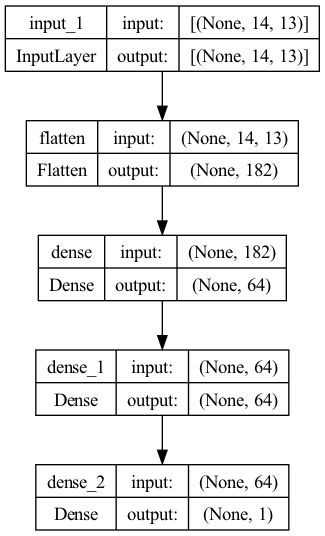

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=5
)

In [94]:
model.evaluate(x_test, y_test)

50/50 [==============================] - 0s 412us/step - loss: 0.2605 - accuracy: 0.9181


[0.2605123817920685, 0.9181249737739563]